# Playground series S3 E7 EDA and model selection

## Import libs

In [594]:
import os 
import sys
import math
import time
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
try:
    import kaleido
except:
    !pip install -U kaleido
    import kaleido

## Constants

In [595]:
# Helpers
ORIGINAL_PATH = "/kaggle/input/reservation-cancellation-prediction"
TEST_ORIGINAL_FILENAME = "test___dataset.csv"
TRAIN_ORIGINAL_FILENAME = "train__dataset.csv"
PATH = "/kaggle/input/playground-series-s3e7"
TRAIN_FILENAME = "train.csv"
TEST_FILENAME = "test.csv"
SUBMISSION_FILENAME = "sample_submission.csv"

# Data dir
TEST_DIR = os.path.join(PATH, TEST_FILENAME)
TRAIN_DIR = os.path.join(PATH, TRAIN_FILENAME)
SUBMISSION_DIR = os.path.join(PATH, SUBMISSION_FILENAME)
TEST_OR_DIR = os.path.join(ORIGINAL_PATH, TEST_ORIGINAL_FILENAME)
TRAIN_OR_DIR = os.path.join(ORIGINAL_PATH, TRAIN_ORIGINAL_FILENAME)

# Column names
NO_OF_ADULTS = 'no_of_adults'
NO_OF_CHILDREN ='no_of_children'
NO_OF_WEEKEND_NIGHTS ='no_of_weekend_nights'
NO_OF_WEEK_NIGHTS ='no_of_week_nights'
TYPE_OF_MEAL_PLAN = 'type_of_meal_plan'
REQUIRED_CAR_PARKING_SPACE = 'required_car_parking_space'
ROOM_TYPE_RESERVED = 'room_type_reserved'
LEAD_TIME = 'lead_time'
ARRIVAL_YEAR = 'arrival_year'
ARRIVAL_MONTH = 'arrival_month'
ARRIVAL_DATE = 'arrival_date'
MARKET_SEGMENT_TYPE = 'market_segment_type'
REPEATED_GUEST = 'repeated_guest'
NO_PREV_CANCELLATIONS = 'no_of_previous_cancellations'
NO_PRED_BOOKING_NOT_CANCELLED = 'no_of_previous_bookings_not_canceled'
AVG_PRICE_X_ROOM = 'avg_price_per_room'
NO_OD_SPECIAL_REQUESTS = 'no_of_special_requests'
TARGET = 'booking_status'

# Artificial values
DAY = "day"
MONTH = "month"
YEAR = "year"
WEEK = "week"
DATE = "date"
MONTH_DAY = "month_day"
WEEK_DAY = "week_day"
YEAR_DAY = "year_day"
QUARTER = "quarter"

In [596]:
BLUE = "#8cfff4"
ROSE = "#f786ae"
YELLOW = "#f2e738"
PURPLE = "#fc60ed"
GREEN = "#5ffa62"
ORANGE = "#ff4603"
L_BLUE = "#44bac7"
D_BLUE = "#27555e"
L_GREEN = "#77d486"

PALETTE = [BLUE, ROSE, GREEN, PURPLE,YELLOW]
grey_palette = [
    '#8e8e93', '#636366', '#48484a', '#3a3a3c', '#2c2c2e', '#1c1c27'
]

## Functions

In [597]:
def data_description(df):
    print("Data description")
    print(f"Total number of records {df.shape[0]}")
    print(f'number of features {df.shape[1]}\n\n')
    columns = df.columns
    data_type = []
    
    # Get the datatype of features
    for col in df.columns:
        data_type.append(df[col].dtype)
        
    n_uni = df.nunique()
    # Number of NaN values
    n_miss = df.isna().sum()
    
    names = list(zip(columns, data_type, n_uni, n_miss))
    variable_desc = pd.DataFrame(names, columns=["Name","Type","Unique levels","Missing"])
    print(variable_desc)

In [598]:
def time_split(df):
    temp = df.rename(columns={
        ARRIVAL_YEAR: YEAR,
        ARRIVAL_MONTH: MONTH,
        ARRIVAL_DATE: DAY
    })
    
    df[DATE] = pd.to_datetime(temp[[YEAR, MONTH, DAY]], errors='coerce')
    df[YEAR] = df[DATE].dt.year
    df[MONTH] = df[DATE].dt.month
    df[WEEK] = df[DATE].dt.isocalendar().week.astype(float)
    df[DAY] = df[DATE].dt.day
    df[WEEK_DAY] = df[DATE].dt.dayofweek
    df[QUARTER] = df[DATE].dt.quarter
    df[YEAR_DAY] = df[DATE].dt.dayofyear
    
    df.drop(columns='date', inplace=True)
    return df

In [599]:
def pie_plot(df: pd.DataFrame, hover_temp: str = "Status: ",
            feature=TARGET, palette=[L_BLUE,"#221e8f"], color=[BLUE ,D_BLUE],
            title="Target distribution"):
    target = df[[feature]].value_counts(normalize=True).sort_index().round(decimals=3)*100
    fig = go.Figure()
    
    fig.add_trace(go.Pie(labels=target.index, values=target, hole=.4,
                        sort=False, showlegend=True, marker=dict(colors=color, line=dict(color=palette,width=2)),
                        hovertemplate = "%{label} " + hover_temp + ": %{value:.2f}%<extra></extra>"))
    
    fig.update_layout(template=temp, title=title, 
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',height=600)
    fig.show()
    

In [600]:
def show_corr_heatmap(df, title):
    
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize = (15, 10))
    plt.title(title)
    sns.heatmap(corr, annot = True, linewidths=.5, fmt=".2f", square=True, mask = mask)
    plt.show()

In [601]:
def plot_bar(col, ax):
    percentage = comb_df.groupby("set")[col].size()
    percentage = percentage.rename("%").reset_index()
    sns.barplot(data=percentage, x=col, y="%",
                hue="set",ax=ax, hue_order=labels)
    
    if percentage.shape[0] > 100:
        ticks = ax.get_xticks()
        text = ax.get_xticklabels()
        
        step = len(ticks)//8
        ax.set_xticks(ticks[::step], text[::step])
        
    plot_ordinal_dots(col, ax)

In [602]:
def plot_ordinals(col, ax, color):
    percentage = comb_df.groupby("set")[col].value_counts(True)
    percentage = percentage.rename("%").reset_index()
    sns.barplot(data=percentage, x=col, y="%",
                hue="set",ax=ax, hue_order=labels, palette="tab20") #PALETTE[0:4]
    
    if percentage.shape[0] > 100:
        ticks = ax.get_xticks()
        text = ax.get_xticklabels()
        
        step = len(ticks)//8
        ax.set_xticks(ticks[::step], text[::step])
        
    plot_ordinal_dots(col, ax)

In [603]:
def plot_cont(col, ax, color=PALETTE[0]):
    sns.histplot(data=comb_df, x=col,
                hue="set",ax=ax, hue_order=labels,
                common_norm=False, **histplot_hyperparams)
    
    ax_2 = ax.twinx()
    ax_2 = plot_cont_dot(
        comb_df.query('set=="train"'),
        col, "booking_status", ax_2,
        color=color
    )
    
    ax_2 = plot_cont_dot(
        comb_df, col,
        "booking_status", ax_2,
        color=color
    )

In [604]:
def plot_cont_dot(
    df, column, target, ax,
    show_yticks=False, color='green'
):

    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df[target]
    target = target.groupby(bins).mean()
    target.plot(
        ax=ax, linestyle="",
        marker=".", color=color,
        label=f"Mean {target.name}"
    )
    ax.grid(visible=False)
    
    if not show_yticks:
        ax.get_yaxis().set_ticks([])
        
    return ax


In [605]:
def plot_ordinal_dots(col, ax):
    dots = comb_df.groupby(["set", col])[TARGET].mean().reset_index(level=1)
    dots.sort_values(col, inplace=True)
    train_containers = ax.containers[0]
    original_containers = ax.containers[2]
    
    cont = [train_containers, original_containers]
    sets = ["train", "original_train"]
    colors = [ORANGE, GREEN]
    x = 0
    
    for set_, container in zip(sets, cont):
        dots_subset = dots.loc[set_]
        
        x_s = [bar.get_x() + bar.get_width()/2 for bar in container]
        y_s = dots_subset.booking_status
        x_s = x_s[:y_s.shape[0]]
        
        ax.plot(x_s, y_s, marker='.', alpha=0.8, 
                linestyle=line_style, markersize=10,
                color=colors[x]
        )
        
        x += 1

## Import data

In [606]:
train_df = pd.read_csv(TRAIN_DIR)
test_df = pd.read_csv(TEST_DIR)
test_or_df = pd.read_csv(TEST_OR_DIR)
train_or_df = pd.read_csv(TRAIN_OR_DIR)
submission_df = pd.read_csv(SUBMISSION_DIR)

In [607]:
data_description(train_df)

Data description
Total number of records 42100
number of features 19


                                    Name     Type  Unique levels  Missing
0                                     id    int64          42100        0
1                           no_of_adults    int64              5        0
2                         no_of_children    int64              6        0
3                   no_of_weekend_nights    int64              8        0
4                      no_of_week_nights    int64             18        0
5                      type_of_meal_plan    int64              4        0
6             required_car_parking_space    int64              2        0
7                     room_type_reserved    int64              7        0
8                              lead_time    int64            338        0
9                           arrival_year    int64              2        0
10                         arrival_month    int64             12        0
11                          arrival_date 

In [608]:
train_df.columns.values

array(['id', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan',
       'required_car_parking_space', 'room_type_reserved', 'lead_time',
       'arrival_year', 'arrival_month', 'arrival_date',
       'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled', 'avg_price_per_room',
       'no_of_special_requests', 'booking_status'], dtype=object)

In [609]:
data_description(test_df)

Data description
Total number of records 28068
number of features 18


                                    Name     Type  Unique levels  Missing
0                                     id    int64          28068        0
1                           no_of_adults    int64              5        0
2                         no_of_children    int64              6        0
3                   no_of_weekend_nights    int64              7        0
4                      no_of_week_nights    int64             18        0
5                      type_of_meal_plan    int64              4        0
6             required_car_parking_space    int64              2        0
7                     room_type_reserved    int64              7        0
8                              lead_time    int64            334        0
9                           arrival_year    int64              2        0
10                         arrival_month    int64             12        0
11                          arrival_date 

In [610]:
data_description(submission_df)

Data description
Total number of records 28068
number of features 2


             Name     Type  Unique levels  Missing
0              id    int64          28068        0
1  booking_status  float64              1        0


In [611]:
data_description(test_or_df)

Data description
Total number of records 18138
number of features 17


                                    Name     Type  Unique levels  Missing
0                           no_of_adults    int64              5        0
1                         no_of_children    int64              5        0
2                   no_of_weekend_nights    int64              7        0
3                      no_of_week_nights    int64             17        0
4                      type_of_meal_plan    int64              4        0
5             required_car_parking_space    int64              2        0
6                     room_type_reserved    int64              7        0
7                              lead_time    int64            343        0
8                           arrival_year    int64              2        0
9                          arrival_month    int64             12        0
10                          arrival_date    int64             31        0
11                   market_segment_type 

In [612]:
data_description(train_or_df)

Data description
Total number of records 18137
number of features 18


                                    Name     Type  Unique levels  Missing
0                           no_of_adults    int64              5        0
1                         no_of_children    int64              5        0
2                   no_of_weekend_nights    int64              8        0
3                      no_of_week_nights    int64             18        0
4                      type_of_meal_plan    int64              4        0
5             required_car_parking_space    int64              2        0
6                     room_type_reserved    int64              7        0
7                              lead_time    int64            341        0
8                           arrival_year    int64              2        0
9                          arrival_month    int64             12        0
10                          arrival_date    int64             31        0
11                   market_segment_type 

In [613]:
CATEGORICAL_COLS = [
    MARKET_SEGMENT_TYPE, REPEATED_GUEST, REQUIRED_CAR_PARKING_SPACE,
    ROOM_TYPE_RESERVED, TYPE_OF_MEAL_PLAN
]

NUM_COLS = [
   LEAD_TIME, AVG_PRICE_X_ROOM
]
ORDINAL_COLS = [
    NO_OF_ADULTS, NO_OF_CHILDREN, NO_OF_WEEKEND_NIGHTS, NO_OF_WEEK_NIGHTS,
    NO_OD_SPECIAL_REQUESTS, NO_PREV_CANCELLATIONS, NO_PRED_BOOKING_NOT_CANCELLED
]

In [614]:
comb_df = pd.concat([
    train_df.assign(set='train'),
    test_df.assign(set='test'),
    train_or_df.assign(set='original_train'),
    test_or_df.assign(set='original_test')
], ignore_index=True)

comb_df.reset_index(drop=True, inplace=True)
labels = ['train', 'test', 'original_train', 'original_test']

In [615]:
train_df = time_split(train_df)
train_or_df = time_split(train_or_df)
comb_df = time_split(comb_df)

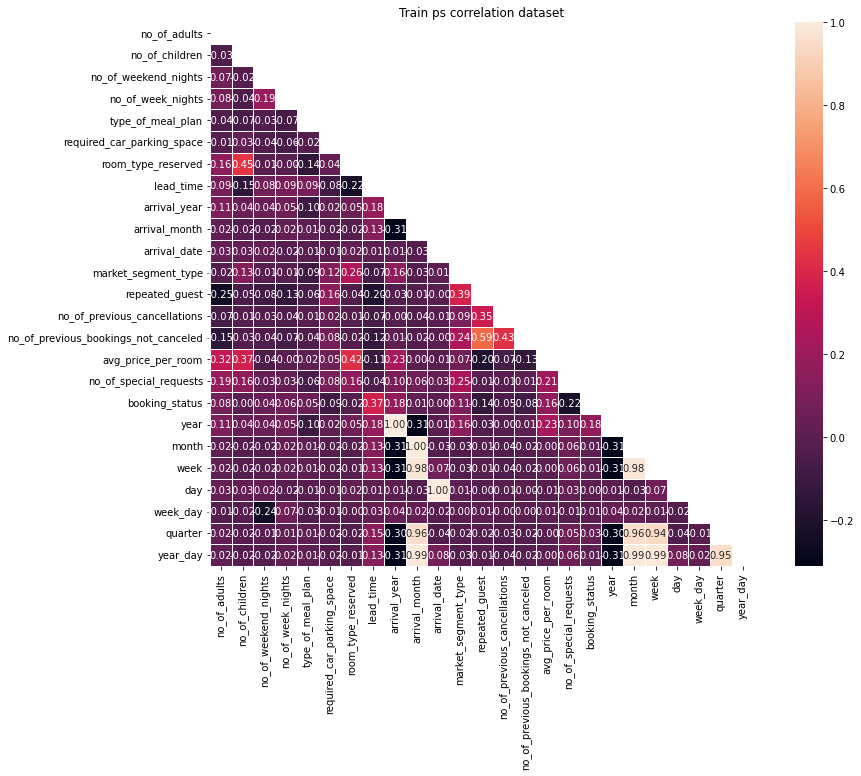

In [616]:
train_df.drop("id", axis=1, inplace=True)
show_corr_heatmap(train_df, "Train ps correlation dataset")

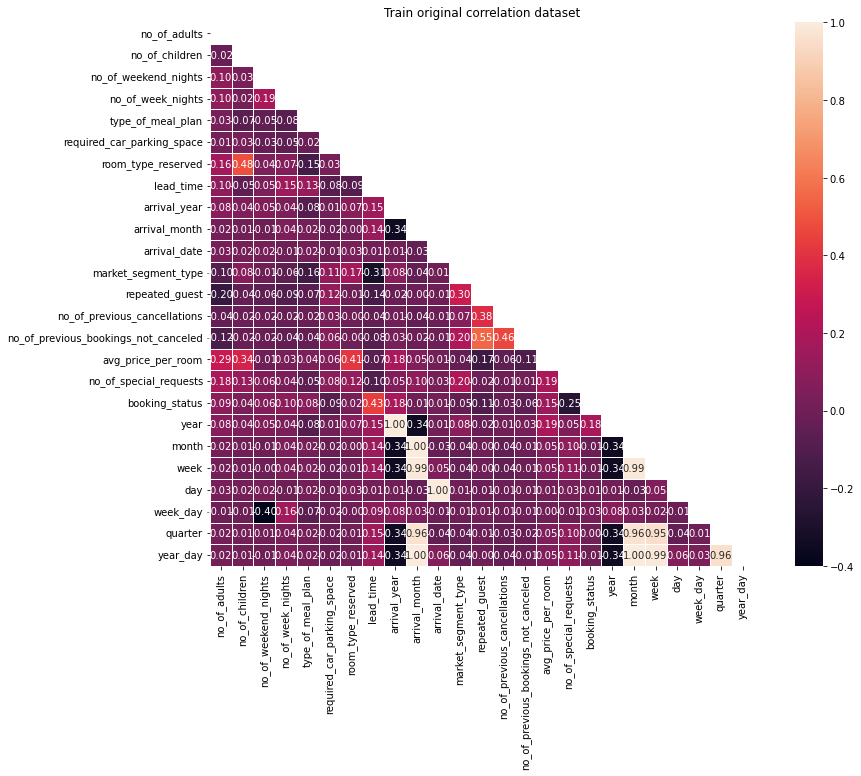

In [617]:
show_corr_heatmap(train_or_df, "Train original correlation dataset")

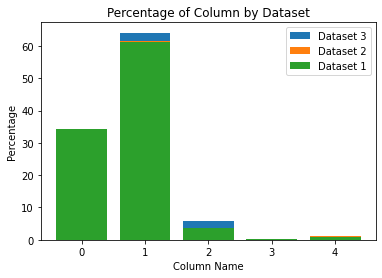

In [618]:
# Calculate the percentage of a column for each dataset
df1_percent = test_df[MARKET_SEGMENT_TYPE].value_counts(normalize=True) * 100
df2_percent = train_df[MARKET_SEGMENT_TYPE].value_counts(normalize=True) * 100
df3_percent = train_or_df.groupby(MARKET_SEGMENT_TYPE).size() / len(train_or_df) * 100

# Create a matplotlib figure and axis object
fig, ax = plt.subplots()

# Use the bar method to plot the percentage values for each dataset
ax.bar(df3_percent.index, df3_percent.values, label='Dataset 3')
ax.bar(df2_percent.index, df2_percent.values, label='Dataset 2')
ax.bar(df1_percent.index, df1_percent.values, label='Dataset 1')

# Add labels and titles
ax.set_xlabel('Column Name')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Column by Dataset')
ax.legend()

plt.show()

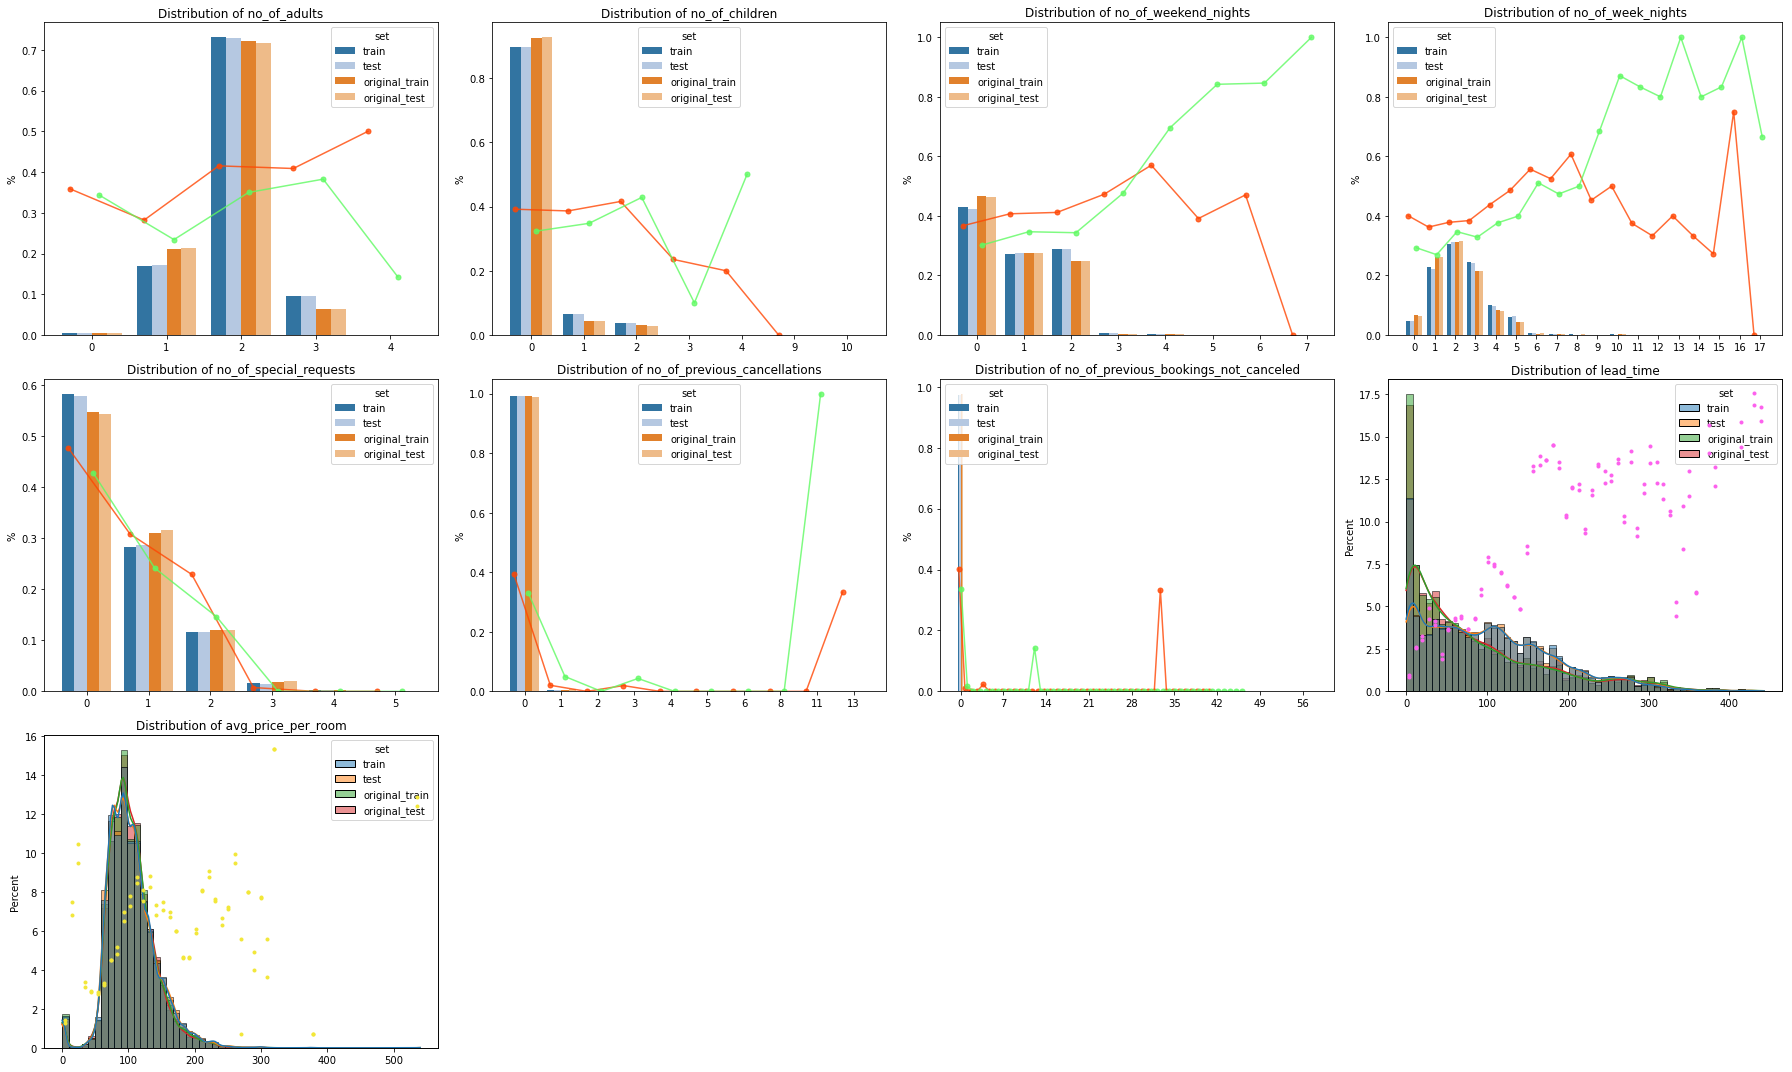

In [619]:
x = 0
n_bins = 55
histplot_hyperparams = {
    "kde":True,
    "alpha":0.5,
    "stat":"percent",
    "bins":n_bins
}
line_style='-'

columns =  ORDINAL_COLS + NUM_COLS
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(25, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(columns):
    if x == 4:
        x = 0
    else:
        x = x + 1
    plot_axes = [ax[i]]
    
    if column in ORDINAL_COLS:
        plot_ordinals(column, ax[i], PALETTE[x])
    else:
        plot_cont(column, ax[i], PALETTE[x])

    # titles
    ax[i].set_title(f"Distribution of {column}");
    ax[i].set_xlabel(None)
    
for i in range(i+1, len(ax)):
    ax[i].axis("off")

plt.tight_layout()

In [620]:
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), height=500, width=1000))

In [621]:
display(pie_plot(df = train_df, hover_temp = "Booking Status", title="Target distribution PS train dataframe"))
display(pie_plot(df = train_or_df, hover_temp = "Booking Status",
                 feature = TARGET, palette = [L_GREEN, GREEN],
                 color = ["#15ed41", "#0e6920"], title = "Target distribution Original train dataframe"))

None

None

<AxesSubplot:xlabel='week_day', ylabel='count'>

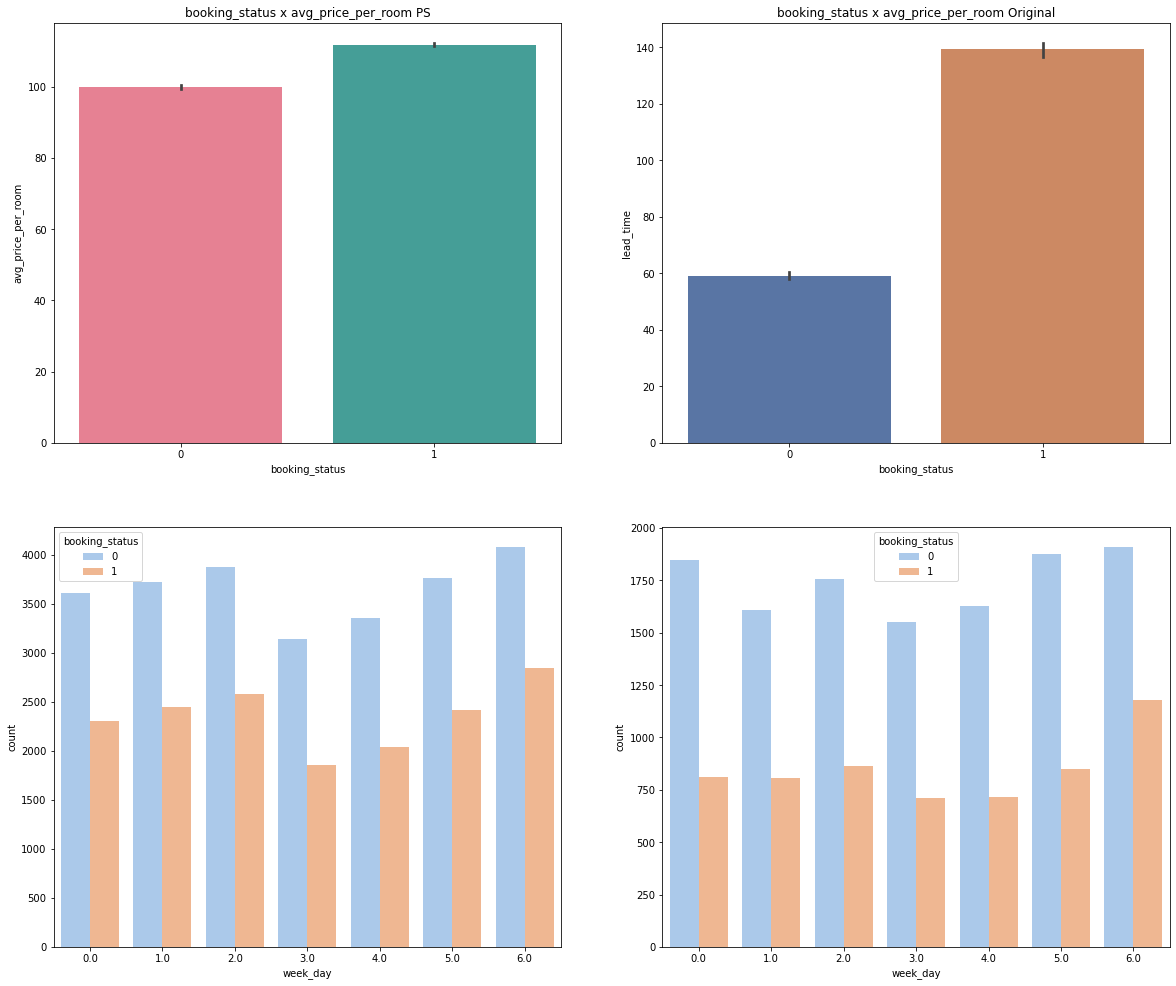

In [622]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 17))
sns.barplot(data=train_df, x=TARGET, y=AVG_PRICE_X_ROOM, ax=axes[0][0], palette="husl")
axes[0][0].set_title(f"{TARGET} x {AVG_PRICE_X_ROOM} PS")
sns.barplot(data=train_or_df, x=TARGET, y=LEAD_TIME, ax=axes[0][1], palette="deep")
axes[0][1].set_title(f"{TARGET} x {AVG_PRICE_X_ROOM} Original")

filtered_df = train_df[train_df[TARGET].isin([0, 1])]
# Create a barplot of the unique WEEK_DAY values for target=0 and target=1
sns.countplot(x=WEEK_DAY, data=filtered_df, hue=TARGET, ax=axes[1][0], palette="pastel")
# true_df = train_df[train_df[TARGET] == 0]

filtered_df = train_or_df[train_or_df[TARGET].isin([0, 1])]
# Create a barplot of the unique WEEK_DAY values for target=0 and target=1
sns.countplot(x=WEEK_DAY, data=filtered_df, hue=TARGET, ax=axes[1][1], palette="pastel")

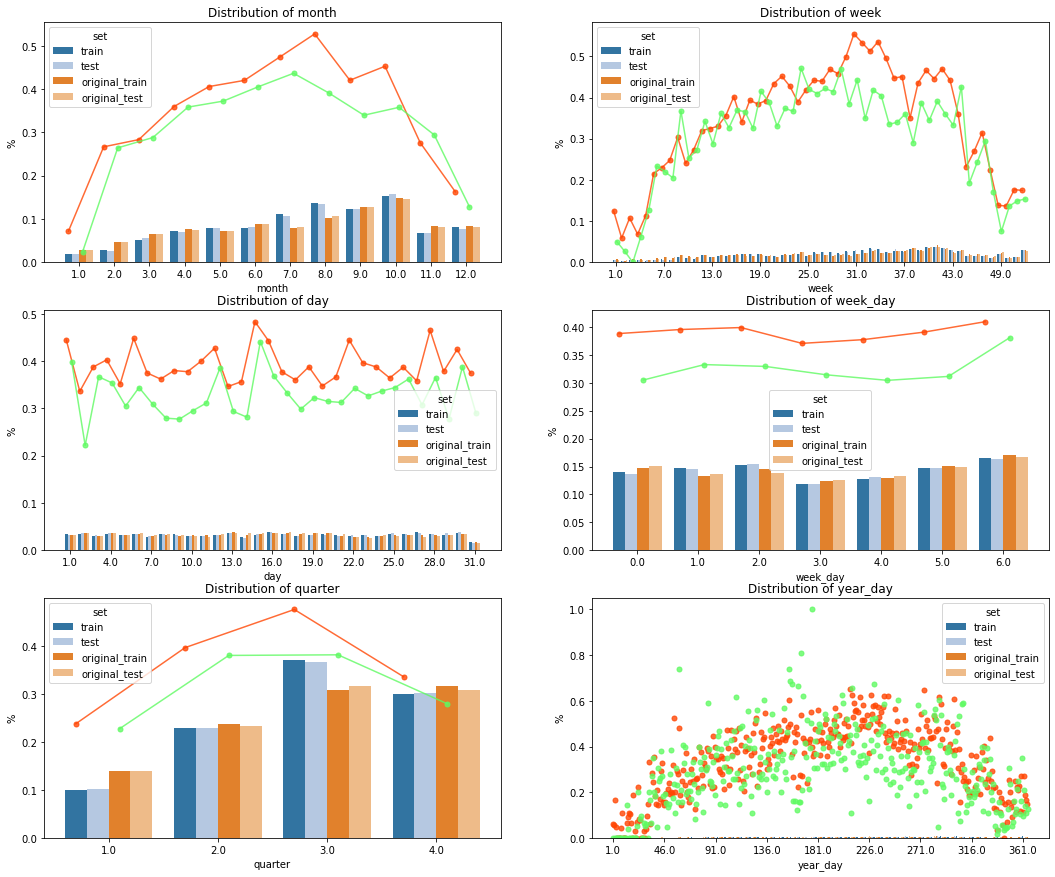

In [623]:
DATE_COLS = [
    MONTH, WEEK, DAY, WEEK_DAY, QUARTER, YEAR_DAY
]

n_cols = 2
n_rows = math.ceil(len(DATE_COLS)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*5))
ax = ax.flatten()

for i, col in enumerate(DATE_COLS):
    if col == YEAR_DAY:
        line_style = ""
    else:
        line_style = "-"
    plot_axes = [ax[i]]
    plot_ordinals(col, ax[i], PALETTE[2])
    ax[i].set_title(f"Distribution of {col}")
    
for i in range(i+1, len(ax)):
    ax[i].axis(False)

In [624]:
X = train_df.drop(TARGET , axis =1 )
y = train_df[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 18,
                                                       test_size =0.3)

In [625]:
FEATURES = [col for col in train_df.columns if col != TARGET]
train_original = X_train.copy()
train_original[TARGET] = y_train.tolist()

In [626]:
FOLDS=5

In [627]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.05,
    'max_depth': 8,
    'num_iterations': 1500,
    'feature_fraction': 0.825,
    'bagging_fraction': 0.585
}

lgb_predictions = 0
lgb_scores = []
lgb_imp = []

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=18)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_original[FEATURES], train_original[TARGET])):
    
    print(5*"#", f"Fold={fold+1}", 5*"#")
    start_time = time.time()
    
    X_train, X_valid = train_original.iloc[train_idx][FEATURES], train_original.iloc[valid_idx][FEATURES]
    y_train , y_valid = train_original[TARGET].iloc[train_idx] , train_original[TARGET].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  preds_valid)
    lgb_scores.append(auc)
    run_time = time.time() - start_time
    
    print(f"Fold={fold+1}, AUC score: {auc:.2f}, Run Time: {run_time:.2f}s")
    fim = pd.DataFrame(index=FEATURES,
                 data=model.feature_importances_,
                 columns=[f"{fold}_importance"])
    lgb_imp.append(fim)
    test_preds = model.predict_proba(X_test[FEATURES])[:, 1]
    lgb_predictions += test_preds/FOLDS
    
print("Mean AUC :", np.mean(lgb_scores))

##### Fold=1 #####
[LightGBM] [Warning] feature_fraction is set=0.825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.825
[LightGBM] [Warning] bagging_fraction is set=0.585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.585


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Fold=1, AUC score: 0.90, Run Time: 1.36s
##### Fold=2 #####


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] feature_fraction is set=0.825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.825
[LightGBM] [Warning] bagging_fraction is set=0.585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.585
Fold=2, AUC score: 0.89, Run Time: 1.34s
##### Fold=3 #####
[LightGBM] [Warning] feature_fraction is set=0.825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.825
[LightGBM] [Warning] bagging_fraction is set=0.585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.585


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Fold=3, AUC score: 0.88, Run Time: 1.40s
##### Fold=4 #####
[LightGBM] [Warning] feature_fraction is set=0.825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.825
[LightGBM] [Warning] bagging_fraction is set=0.585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.585


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Fold=4, AUC score: 0.90, Run Time: 2.02s
##### Fold=5 #####
[LightGBM] [Warning] feature_fraction is set=0.825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.825
[LightGBM] [Warning] bagging_fraction is set=0.585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.585


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Fold=5, AUC score: 0.89, Run Time: 1.29s
Mean AUC : 0.8899226153650457


In [628]:
roc_auc_score(y_test, lgb_predictions)

0.8984201599499165

In [629]:
test_df = time_split(test_df)
submission_df[TARGET] = model.predict_proba(test_df[FEATURES])[:,1]
submission_df.to_csv("submission.csv", index=False)

### The model and data analysis is in process, it will be updated in the next days, if you liked it or if it helped you feel free to leave your upvote.